In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import numpy as np
import hvplot.xarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from dask.distributed import Client

client = Client()
client

Client Scheduler: tcp://127.0.0.1:60488 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


#### My edits to this notebook mainly focus on making the code for the plots more efficient by creating some functions that will hopefully be useful to other notebooks as well. I also shortened opening the dataset by making a list of the urls so that everything is contained in one dataset, which will be more efficient, especially if you deal with big data.

A global coupled ocean-atmosphere general circulation model - [CMIP5 (Coupled Model Intercomparison Project Phase 5)](https://esgf-node.llnl.gov/projects/esgf-llnl/)

This particular output that I chose starts in 1985 and ends in 1995, with monthly frequency and has atmosphereic variables. There are 42 files associated with this output, one file for each variable. Other versions of CMIP5 have sea ice and ocean variables. The search filter for different products is found at [ESGF@DOE/LLNL](https://esgf-node.llnl.gov/projects/esgf-llnl/)(The Earth System Grid Federation @ 
the Department of Energy/ Lawrence Livermore National Laboratory).
Only certain data products are unrestricted and can be downloaded via Globus, HTTP, and OpenDAP download. The typical format is NetCDF. 

This notebook reads in the 42 files as a multi-file dataset. 

*** Direct Link [CMIP5 Data](https://esgf-node.llnl.gov/search/cmip5/)


In [69]:
# Some variables
urls = ['http://aims3.llnl.gov/thredds/dodsC/cmip5_css02_data/cmip5/output1/CMCC/CMCC-CM/decadal1985/mon/atmos/Amon/r1i2p1/pr/1/pr_Amon_CMCC-CM_decadal1985_r1i2p1_198511-199512.nc',
        'http://aims3.llnl.gov/thredds/dodsC/cmip5_css02_data/cmip5/output1/CMCC/CMCC-CM/decadal1985/mon/atmos/Amon/r1i2p1/ts/1/ts_Amon_CMCC-CM_decadal1985_r1i2p1_198511-199512.nc',
        'http://aims3.llnl.gov/thredds/dodsC/cmip5_css02_data/cmip5/output1/CMCC/CMCC-CM/decadal1985/mon/atmos/Amon/r1i2p1/zg/1/zg_Amon_CMCC-CM_decadal1985_r1i2p1_198511-199512.nc',
        'http://aims3.llnl.gov/thredds/dodsC/cmip5_css02_data/cmip5/output1/CMCC/CMCC-CM/decadal1985/mon/atmos/Amon/r1i2p1/ps/1/ps_Amon_CMCC-CM_decadal1985_r1i2p1_198511-199512.nc' 
       ]
ds = xr.open_mfdataset(urls)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 240, lon: 480, plev: 17, time: 122)
Coordinates:
  * time       (time) datetime64[ns] 1985-11-16 ... 1995-12-16T12:00:00
  * lat        (lat) float64 -89.43 -88.68 -87.94 -87.19 ... 87.94 88.68 89.43
  * lon        (lon) float64 0.0 0.75 1.5 2.25 3.0 ... 357.0 357.8 358.5 359.2
  * plev       (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 3e+03 2e+03 1e+03
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(122, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(240, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(480, 2), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(122, 240, 480), meta=np.ndarray>
    ps         (time, lat, lon) float32 dask.array<chunksize=(122, 240, 480), meta=np.ndarray>
    ts         (time, lat, lon) float32 dask.array<chunksize=(122, 240, 480), meta=np.ndarray>
    zg         (time, plev, lat, lon) float32 dask.array<chunksize=(122, 17, 240, 480), meta=np.ndarray>
Attributes:
    institution:                     CMCC - Centro Euro-Mediterraneo per i Ca...
    institute_id:                    CMCC
    experiment_id:                   decadal1985
    source:                          CMCC-CM
    model_id:                        CMCC-CM
    forcing:                         Nat,Ant,GHG,SA,TO,Sl
    parent_experiment_id:            N/A
    parent_experiment_rip:           N/A
    branch_time:                     0.0
    contact:                         Silvio Gualdi (gualdi@bo.ingv.it)
    history:                         Model output postprocessed with CDO 2012...
    comment:                         The ocean is initialized with full value...
    references:                      model described in the documentation at ...
    initialization_method:           2
    physics_version:                 1
    tracking_id:                     5c002496-4c26-45ce-8626-e03d3fb426ce
    product:                         output
    experiment:                      10- or 30-year run initialized in year 1985
    frequency:                       mon
    creation_date:                   2012-03-22T15:29:33Z
    Conventions:                     CF-1.4
    project_id:                      CMIP5
    table_id:                        Table Amon (27 April 2011) a5a1c518f52ae...
    title:                           CMCC-CM model output prepared for CMIP5 ...
    parent_experiment:               N/A
    modeling_realm:                  atmos
    realization:                     1
    cmor_version:                    2.7.1
    DODS_EXTRA.Unlimited_Dimension:  time

I think this code can be cleaned up and generalized a bit. I don't think using meshgrid to extract the coordinates is the most efficient way to do this, you could use xarray style syntax and just use .load() or .compute to pull out the values. Also, this colorbar for this code only matches the default image size and will not scale linearly with the figure size if changed. Here's an example:

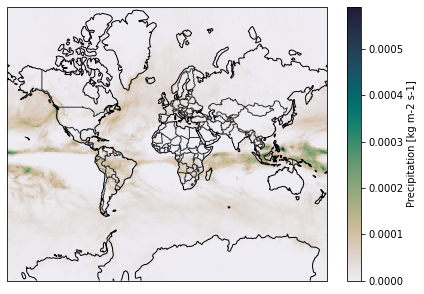

In [70]:
lat = ds.lat.load()
lon = ds.lon.load()

fig = plt.figure()

ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.Mercator())
mappable = ax.pcolormesh(lon, lat, ds.pr[1,:,:], cmap = cmo.rain, transform = ccrs.PlateCarree())
cbar = fig.colorbar(mappable)
cbar.set_label('Precipitation [kg m-2 s-1]')

ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='0.2')

If we know we're making the same plot type for different data, write a function to help reduce the code length. Obviously you can make this much more complicated so than you can change the outputs after the fact, or change the inputs to include vmin & vmax, additional labels, etc. 

In [75]:
plt.rcParams.update({'font.size': 16})

In [76]:
def make_plots(lon, lat, var, cmap, label):
    ''' 
    This function creates generalized code for plotting output from the CMIP5 dataset. 
    Note that I don't return anything because the figure is already generated. This format
    is extremely flexible to include different plot attributes.

    Inputs:
    ------
    lon: loaded grid cell longitude (xarray dataarray)
    lat: loaded grid cell latitude (xarray dataarray)
    var: variable of interest 
    cmap: colomap for pcolormesh
    label: colorbar label

    Outputs:
    ------
    specific figure
    '''
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_axes([0.06, 0.01, 0.93, 0.95], projection=ccrs.Mercator())
    
    mappable = ax.pcolormesh(lon, lat, var, cmap = cmap, transform = ccrs.PlateCarree())
    cbar = fig.colorbar(mappable, shrink = 0.67,pad=0.025) 
    #This is an approximate way to solve the problem with colorbar matching figsize
    #But doing it properly would be mutch more complicated
    cbar.set_label(label)

    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='0.2')

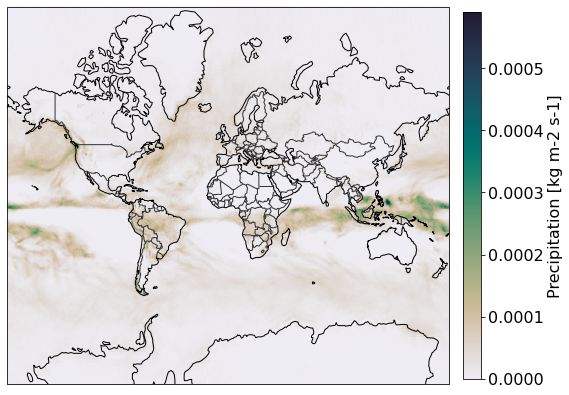

In [77]:
make_plots(lon, lat, ds.pr[1,:,:], cmo.rain, 'Precipitation [kg m-2 s-1]')

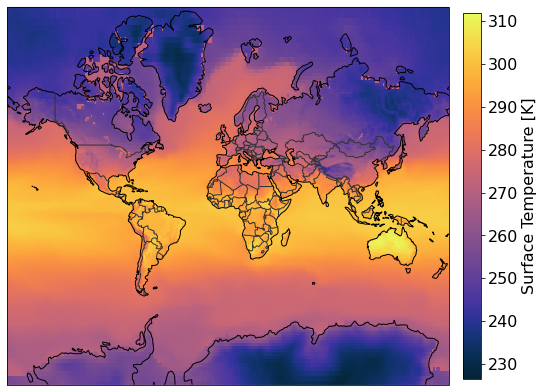

In [78]:
make_plots(lon, lat, ds.ts[1,:,:], cmo.thermal, 'Surface Temperature [K]')

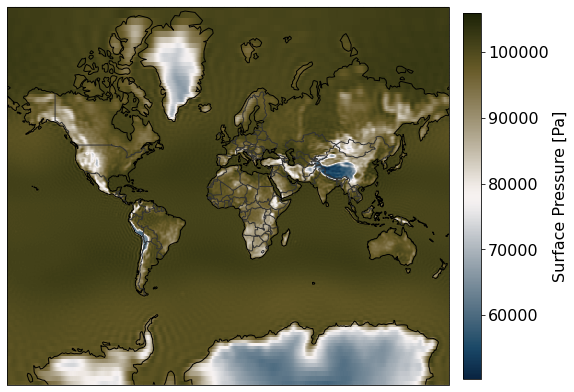

In [79]:
make_plots(lon, lat, ds.ps[1,:,:], cmo.diff, 'Surface Pressure [Pa]')